# Catch and Shoot Rate EDA and Model
In this notebook, I will explore the relationships of different player stats and their future catch and shoot rate.  

Goals:
- Look for what stats might best predict catch and shoot rate.
- Find the best model to make accurate predictions.

Conclusions: 
- A player's future catch-and-shoot rate is almost entirely determined by their previous catch-and-shoot rate.

## 0. Importing Libraries and Data

In [2]:
# Importing standard libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Importing SKlearn libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, RFECV, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
# Importing created functions
from dictionaries import stat_types
from df_functions import use_history
from model_prep import corr_finder, data_split, feature_selection_corr, shift_data
from graphing import corr_plots, box_plots, graph_results

In [3]:
# Importing data
master_df = pd.read_csv('./data/master_df', index_col=0)

## 1. Create Train, Validate, and Test Sets
#### Create X and y

In [12]:
# Saving the data for all player seasons where they had at least 50 post-ups
post_index = master_df[(master_df['CATCH_SHOOT_FGA'] * master_df['GP']) >= 50].index
data = master_df.loc[post_index]

In [13]:
# Matching player data with the target data in the following year
data = shift_data(data, 'PLAYER_ID', ['CATCH_SHOOT_RATE'])

In [14]:
# Setting up the initial X and y
y = data.loc[:, ['TARGET_CATCH_SHOOT_RATE']]
X = data.drop(columns='TARGET_CATCH_SHOOT_RATE')

#### Splitting X and y into train, validate, and test sets

In [15]:
# Creating the train, validate, and test sets for post-up expected value
X_train, X_validate, X_test, y_train, y_validate, y_test = data_split(X, y, 'CATCH_SHOOT_RATE')

## 2. Determine Potential Features
- Taking and making shots is important.
- Also, stats that are related to ball handlers (drives, assists) are negatively correlated.

#### Finding correlated features

In [16]:
# Saving a list of possible numerical features
numeric_columns = list(data.dropna(axis=1).select_dtypes(['float', 'int']).columns)
numeric_columns.remove('TEAM_ID')
numeric_columns.remove('PLAYER_ID')
numeric_columns.remove('2018')

In [17]:
# Looking for features with the highest correlation with the target
corr_features = corr_finder(X_train[numeric_columns], y_train, .3, 10)

In [18]:
# Looking at the most correlated features with the target
corr_features

['CATCH_SHOOT_FGA_PER_MIN_WEIGHTED',
 'CATCH_SHOOT_RATE_WEIGHTED',
 'CATCH_SHOOT_RATE',
 'CATCH_SHOOT_FGA_PER_MIN',
 'CATCH_SHOOT_FGM_PER_MIN_WEIGHTED',
 'CATCH_SHOOT_FGM_PER_MIN',
 'CATCH_SHOOT_PTS_PER_MIN_WEIGHTED',
 'CATCH_SHOOT_PTS_PER_MIN',
 'CATCH_SHOOT_FGM_WEIGHTED',
 'CATCH_SHOOT_FGM']

In [20]:
# Finding the most correlated features that are not correlated with each other
corr_features = feature_selection_corr(X_train[numeric_columns], y_train['TARGET_CATCH_SHOOT_RATE'], alpha=.4)

#### Graphing correlated features

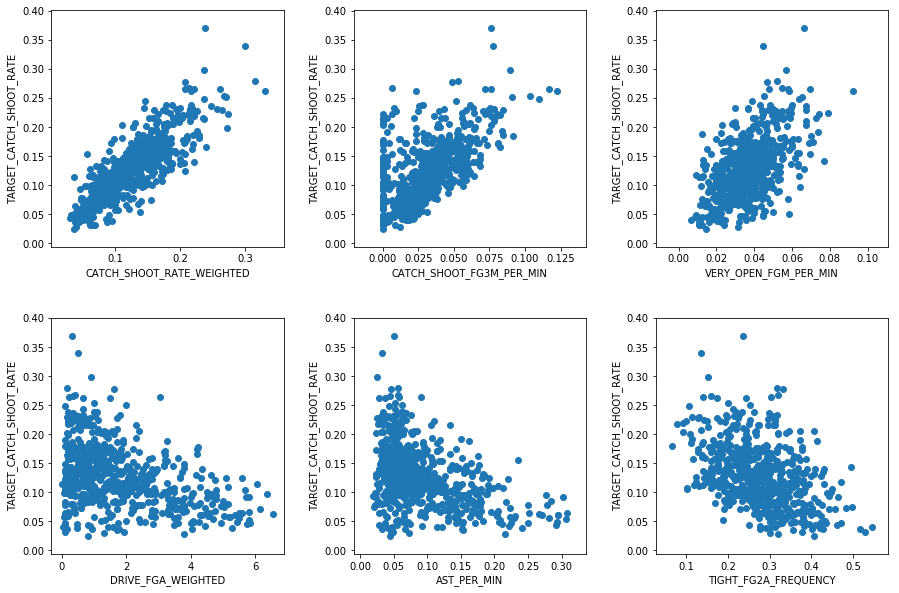

In [21]:
# Plotting those features
corr_plots(X_train, y_train, corr_features);

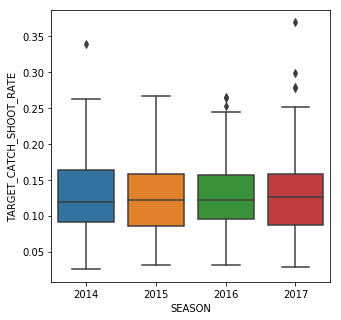

In [22]:
box_plots(X_train, y_train, ['SEASON'], cols=1)

#### Looking at driving and age

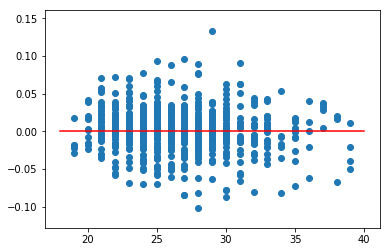

In [85]:
plt.scatter(X_train['AGE'], y_train['TARGET_CATCH_SHOOT_RATE'] - X_train['CATCH_SHOOT_RATE'])
plt.plot([18,40], [0,0], color='r');

## 3. Modeling

#### RFECV
- Used significantly more features than any of the previous model (for other targets).
- Score was high compared to past model (for other targets).

In [24]:
# Using recursive feature elimination to attempt to select features for the model
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True)
rfecv = RFECV(estimator=model, step=1, cv=kfolds)
rfecv.fit(X_train[numeric_columns], y_train.iloc[:,0])
rfecv.n_features_

57

In [25]:
# Checking which features were selected
X_train[numeric_columns].columns[rfecv.get_support(indices=True)]

Index(['SEASON', 'AGE', 'GP', 'W', 'L', 'PTS_PER_POST_TOUCH',
       'PTS_PER_PAINT_TOUCH', 'CATCH_SHOOT_EFG_PCT', 'PULL_UP_EFG_PCT',
       'POST_TOUCH_PTS_PCT', 'PAINT_TOUCH_PTS_PCT', 'CATCH_SHOOT_EV',
       'CATCH_SHOOT_RATE', 'PULL_UP_EV', 'PULL_UP_RATE', 'FGM_PER_MIN',
       'FGM_PG_PER_MIN', 'DIST_MILES_PER_MIN', 'CATCH_SHOOT_FGA_PER_MIN',
       'PULL_UP_FGA_PER_MIN', 'POST_TOUCH_FGA_PER_MIN',
       'POST_TOUCH_FTM_PER_MIN', 'POST_TOUCH_FTA_PER_MIN',
       'POST_TOUCH_AST_PER_MIN', 'OPEN_FGM_PER_MIN', 'OPEN_FG2M_PER_MIN',
       'OPEN_FG3M_PER_MIN', '2_DRIBBLES_FGA_PER_MIN',
       '2_DRIBBLES_FG2A_PER_MIN', '2_DRIBBLES_FG3A_PER_MIN', 'SEASON_WEIGHTED',
       'AGE_WEIGHTED', 'GP_WEIGHTED', 'W_WEIGHTED', 'L_WEIGHTED',
       'PTS_PER_POST_TOUCH_WEIGHTED', 'PTS_PER_PAINT_TOUCH_WEIGHTED',
       'CATCH_SHOOT_EFG_PCT_WEIGHTED', 'PULL_UP_EFG_PCT_WEIGHTED',
       'POST_TOUCH_PTS_PCT_WEIGHTED', 'PAINT_TOUCH_PTS_PCT_WEIGHTED',
       'CATCH_SHOOT_EV_WEIGHTED', 'CATCH_SHOOT_RATE_WE

In [26]:
# Checking out the score with the validation data
rfecv.score(X_validate[numeric_columns], y_validate)

-3.697620842229855e+18

#### K BEST
- Surprisingly, the scores got worse as the number of features increased.
- Just using the current season driving rate seemed to get the best score.

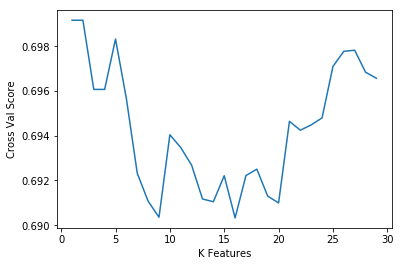

In [27]:
# Looping to select the best k for select k best feature selection
k_scores = []
for k in range(1, 30):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending cross val scores for those features
    model = LinearRegression()
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    k_scores.append(cross_val_score(model, X_train[model_features], y_train, cv=kfolds).mean())
    
plt.plot(range(1, 30), k_scores)
plt.xlabel('K Features')
plt.ylabel('Cross Val Score');

1  Feature Cross Val Scores:  [0.72072482 0.74670172 0.58458303 0.72802011 0.71576986]
2  Feature Cross Val Scores:  [0.72072482 0.74670172 0.58458303 0.72802011 0.71576986]
3  Feature Cross Val Scores:  [0.71373741 0.74433291 0.58549652 0.72589039 0.71088373]
4  Feature Cross Val Scores:  [0.71373741 0.74433291 0.58549652 0.72589039 0.71088373]
5  Feature Cross Val Scores:  [0.71246308 0.73574648 0.59660958 0.7287887  0.71799679]
6  Feature Cross Val Scores:  [0.71205875 0.72960372 0.59512197 0.72404524 0.71744163]


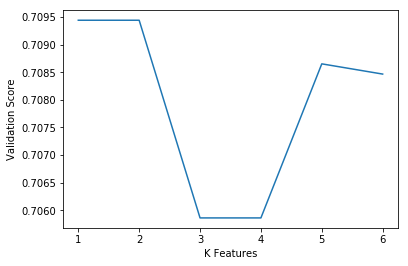

In [40]:
# Checking out 5 - 10 features
k_scores = []
for k in range(1, 7):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending the validation scores
    model = LinearRegression()
    model.fit(X_train[model_features], y_train)
    k_scores.append(model.score(X_validate[model_features], y_validate))
    
    # Printing out the cross val scores
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    print(k, ' Feature Cross Val Scores: ', cross_val_score(model, X_train[model_features], y_train, cv=kfolds))
    
# Graphing the validations scores
plt.plot(range(1, 7), k_scores)
plt.xlabel('K Features')
plt.ylabel('Validation Score');

In [41]:
# Printing out the scores with 5 features
k_best = SelectKBest(f_regression, k=5)
k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

0.7086530137431271

In [42]:
# Printing the model features
model_features

['CATCH_SHOOT_RATE',
 'CATCH_SHOOT_FGA_PER_MIN',
 'CATCH_SHOOT_RATE_WEIGHTED',
 'CATCH_SHOOT_FGM_PER_MIN_WEIGHTED',
 'CATCH_SHOOT_FGA_PER_MIN_WEIGHTED']

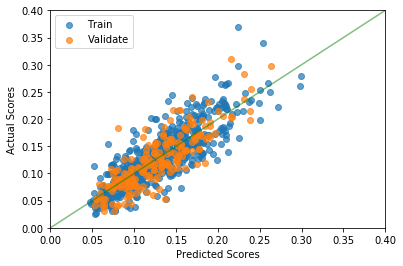

In [46]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train[model_features], y_train, X_validate[model_features], y_validate, model, axis_max=.4)

#### PCA
- The jump from 2 to 3 features was enormous.
- It is still is performing worse than other models.

In [108]:
# Fitting PCA and checking the explained variance
pca = PCA(n_components=15)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_validate_scaled = scaler.transform(X_validate[numeric_columns])
pca.fit(X_train_scaled)
explained_var = pca.explained_variance_ratio_
explained_var

array([0.29633644, 0.19423281, 0.07090736, 0.04018472, 0.03016575,
       0.02565426, 0.02136398, 0.01813346, 0.01685998, 0.01528521,
       0.014276  , 0.01222381, 0.01014755, 0.0096159 , 0.00916186])

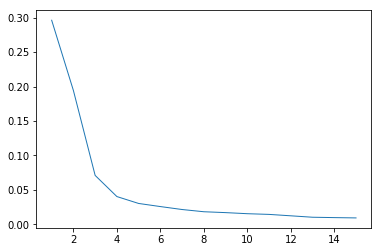

In [109]:
# Looking at the graph of explained variance and looking for the "elbow"
plt.plot(range(1, len(explained_var) + 1), explained_var, lw=1);

In [131]:
# Looking at the cross val score
pca = PCA(n_components=3)
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()
cross_val_score(model, pca.fit_transform(X_train_scaled), y_train, cv=kfolds)

array([0.59741271, 0.54277173, 0.4778458 , 0.62832306, 0.59807701])

In [132]:
# Seeing the score on the validation set
model = LinearRegression()
model.fit(pca.transform(X_train_scaled), y_train)
model.score(pca.transform(X_validate_scaled), y_validate)

0.4839415014638478

#### Neural Net
- Graph has a strange pattern. Higher predicted scores were too low.
- Performed better than past neural nets, but was still not as good as other models.

In [51]:
# Preparing a neural net with all possible features
model_features = data[numeric_columns].dropna(axis=1).columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [52]:
# Creating the neural net
model = Sequential()
model.add(Dense(len(model_features), activation='relu', input_dim=len(model_features)))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/2), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/4), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/8), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/16), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/32), activation='relu', kernel_regularizer=regularizers.l2(.01)))
model.add(Dense(1, activation=None))

In [53]:
# Compiling the neural net and setting an early stopping feature
model.compile(loss='mean_squared_error', optimizer='adam')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=50)

In [54]:
# Fitting the neural net
model.fit(X_train_scaled, y_train, validation_data=(X_validate_scaled, y_validate),epochs=1000,
          callbacks=[early], verbose=0);

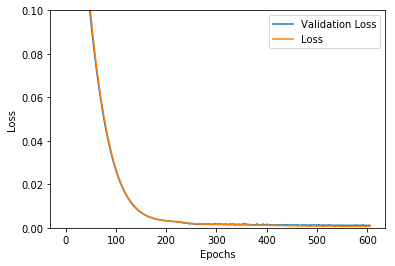

In [55]:
# Plotting the loss over epochs while training
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.plot(model.history.history['loss'], label='Loss')
plt.ylim(0,.1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [56]:
# Finding the r2 score on the validation set
r2_score(y_validate, model.predict(X_validate_scaled))

0.5988632613053944

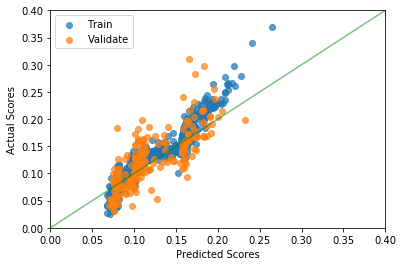

In [58]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, model, axis_max=.4)

#### Linear Regression with My Selected Features
- These features are based on correlations that I saw, features that go into post-up rate, and features that I wanted to experiment with.
- The scores seem similar to the 1 feature model.

In [59]:
# Saving the model features
model_features = ['PULL_UP_EV_WEIGHTED', 'CATCH_SHOOT_RATE_WEIGHTED', 'DRIVE_RATE_WEIGHTED',
                  'POST_TOUCH_RATE_WEIGHTED', 'PLAYER_HEIGHT_INCHES', 'SKINNY', 'AGE', '2015', '2016', '2017']

In [60]:
# Finding the cross validation score
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_score(model, X_train[model_features], y_train, cv=kfolds)

array([0.71814037, 0.73926797, 0.59547799, 0.74001934, 0.71436684])

In [61]:
# Checking the validation scores
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

0.7105053634038683

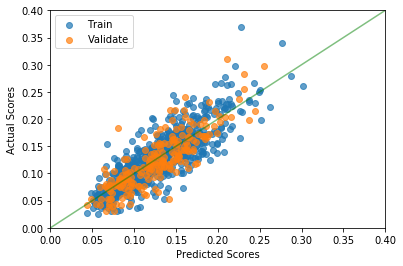

In [63]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train[model_features], y_train, X_validate[model_features], y_validate, model, axis_max=.4)

#### Regularized Linear Regression with My Selected Features
- These scores are slightly improved compared to the linear regression.
- Drive rate in the current season dominated both of their predictions.

In [64]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [92]:
# Testing out ridge regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
ridge_cv = RidgeCV(alphas=np.logspace(-1,3,100), cv=kfolds)
ridge_cv.fit(X_train_scaled, y_train)
ridge = Ridge(alpha=ridge_cv.alpha_)
cross_val_score(ridge, X_train_scaled, y_train, cv=kfolds)

array([0.71772668, 0.73803684, 0.59511183, 0.74338176, 0.71432865])

In [93]:
# Seeing the score on the validation set
ridge.fit(X_train_scaled, y_train)
ridge.score(X_validate_scaled, y_validate)

0.709390807636243

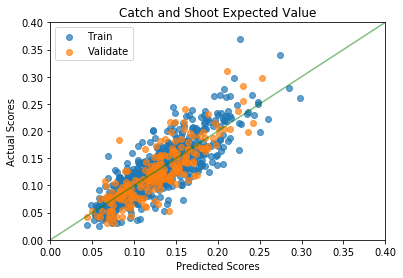

In [94]:
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, ridge, axis_max=.4)
plt.title('Catch and Shoot Expected Value');

In [95]:
# Testing out lasso regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
lasso_cv = LassoCV(alphas=np.linspace(.01,1,100), cv=kfolds)
lasso_cv.fit(X_train_scaled, y_train)
lasso = Lasso(alpha=lasso_cv.alpha_)
cross_val_score(lasso, X_train_scaled, y_train, cv=kfolds)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.66771801, 0.70225624, 0.55264292, 0.73538337, 0.66927211])

In [96]:
# Seeing the score on the validation set
lasso.fit(X_train_scaled, y_train)
lasso.score(X_validate_scaled, y_validate)

0.6624430648260997

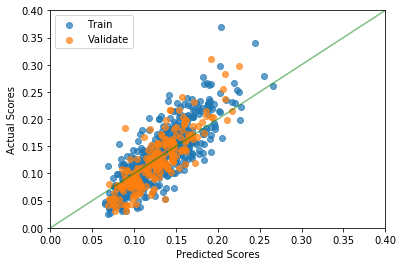

In [97]:
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, lasso, axis_max=.4)

In [98]:
# Looking at the selected features
lasso_coefs = pd.DataFrame(lasso.coef_, index=model_features, columns=['LASSO'])
ridge_coefs = pd.DataFrame(ridge.coef_, columns=model_features, index=['RIDGE']).T
pd.concat([lasso_coefs, ridge_coefs], axis=1)

,LASSO,RIDGE
PULL_UP_EV_WEIGHTED,0.000000,0.002603
CATCH_SHOOT_RATE_WEIGHTED,0.034256,0.041581
DRIVE_RATE_WEIGHTED,-0.000000,-0.002083
POST_TOUCH_RATE_WEIGHTED,0.000000,-0.000315
PLAYER_HEIGHT_INCHES,0.000000,0.003613
SKINNY,-0.000000,-0.001354
AGE,-0.000000,-0.002040
2015,-0.000000,-0.001468
2016,0.000000,0.001012
2017,-0.000000,-0.000569


#### Final scores (Ridge)
- The r2 score on the test set was lower than the better of the cross validation scores.
- There was a 6.5 percent improvement in the rmse compared to the baseline using the test set.

In [99]:
# Linear model score on test data
X_test_scaled = scaler.transform(X_test[model_features])
r2_score(y_test, ridge.predict(X_test_scaled))

0.741694405957743

In [100]:
# Root mean squared error
rmse = mean_squared_error(y_test, ridge.predict(X_test_scaled)) ** .5
rmse

0.028907280264432025

In [101]:
# The score if the prediction was just the value from the current year 
baseline = mean_squared_error(y_test, X_test['CATCH_SHOOT_RATE']) ** .5
baseline

0.03042556859147852

In [102]:
# Looking at the percent improvement (test set)
1 - rmse/baseline

0.049901724021411686

#### Looking to correct the undervaluing/overvaluing problem (Future)

In [80]:
# Creating a training set
train = pd.merge(X_train, y_train, left_index=True, right_index=True)
train['PREDICTED_CATCH_SHOOT_RATE'] = ridge.predict(X_train_scaled)

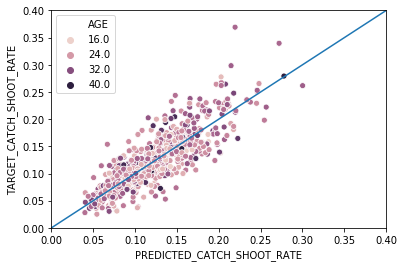

In [82]:
sns.scatterplot('PREDICTED_CATCH_SHOOT_RATE', 'TARGET_CATCH_SHOOT_RATE', data=train, hue='AGE')
plt.plot([0,.4], [0,.4])
plt.xlim(0, .4)
plt.ylim(0, .4);